<a href="https://colab.research.google.com/github/alizard212/111A/blob/main/stability_analysis_LADHAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Ali Niknejad HR_03-01-2025_12_54_13.xlsx to Ali Niknejad HR_03-01-2025_12_54_13 (8).xlsx


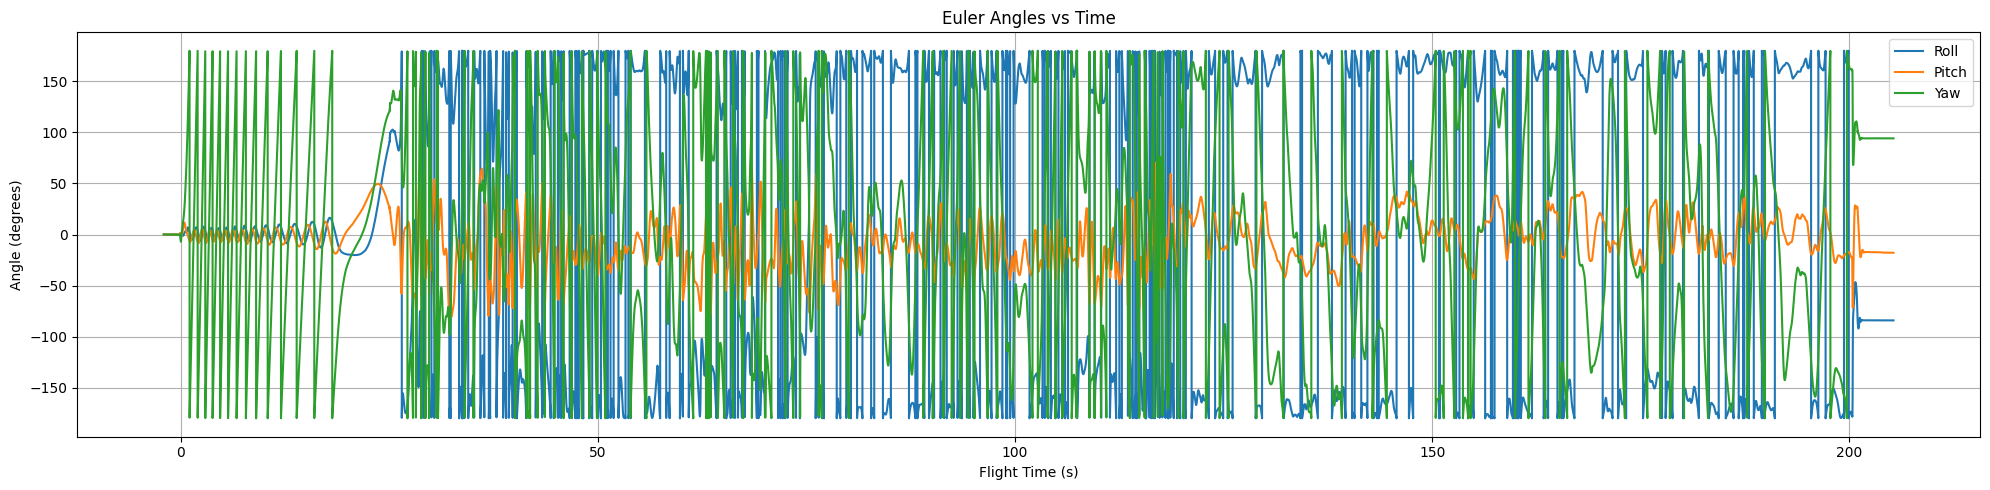

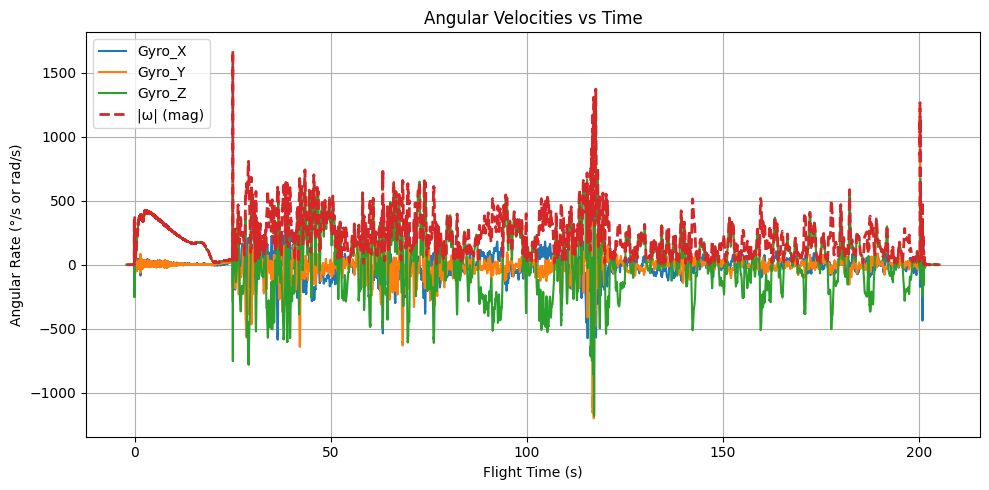

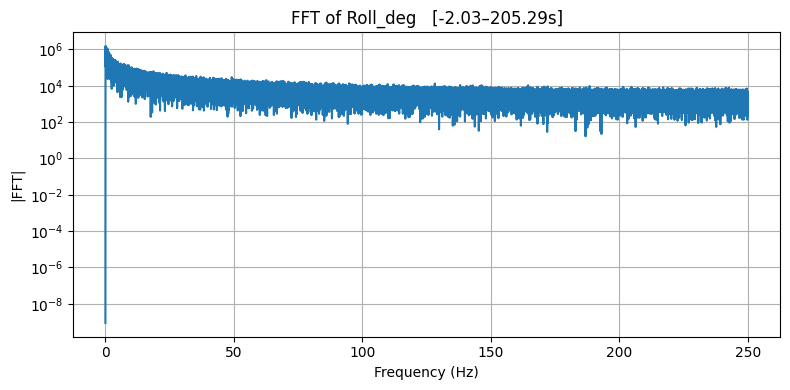

Samples used: 103660 | dt ≈ 0.0020s | fs ≈ 500.00 Hz | Freq‑res ≈ 0.005 Hz


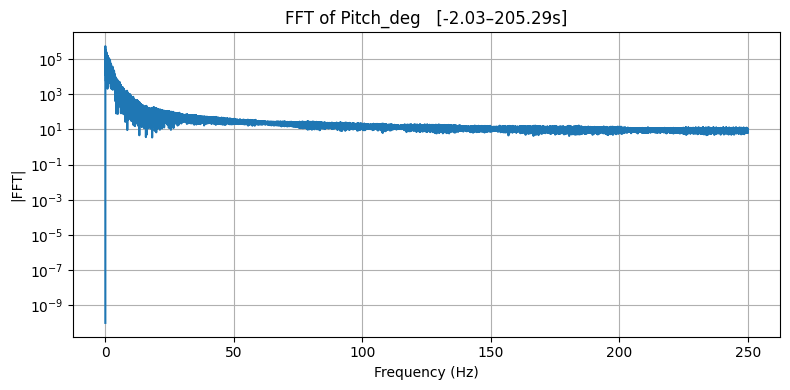

Samples used: 103660 | dt ≈ 0.0020s | fs ≈ 500.00 Hz | Freq‑res ≈ 0.005 Hz


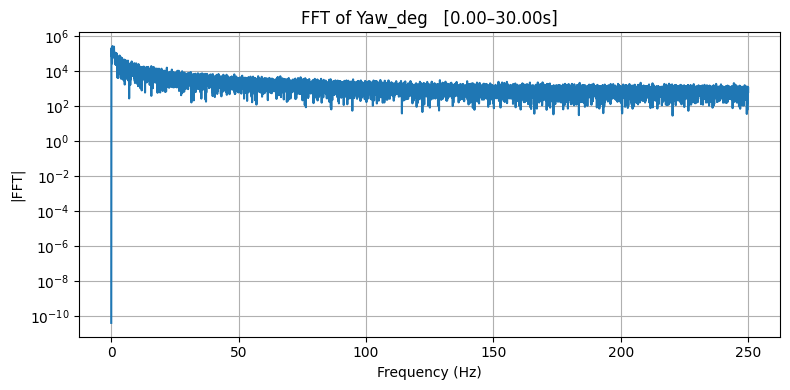

Samples used: 15001 | dt ≈ 0.0020s | fs ≈ 500.00 Hz | Freq‑res ≈ 0.033 Hz


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

from google.colab import files
uploaded = files.upload()

filename = "Ali Niknejad HR_03-01-2025_12_54_13.xlsx"
df_raw = pd.read_excel(filename, sheet_name=0)


def quat_to_euler(df):
    w, x, y, z = df["Quat_1"], df["Quat_2"], df["Quat_3"], df["Quat_4"]

    roll = np.arctan2(2*(w*x + y*z), 1 - 2*(x**2 + y**2))
    pitch = np.arcsin(np.clip(2*(w*y - z*x), -1.0, 1.0))
    yaw = np.arctan2(2*(w*z + x*y), 1 - 2*(y**2 + z**2))

    df = df.copy()
    df["Roll_deg"] = np.degrees(roll)
    df["Pitch_deg"] = np.degrees(pitch)
    df["Yaw_deg"] = np.degrees(yaw)
    return df

df = quat_to_euler(df_raw)


def plot_euler(df):
    t = df["Flight_Time_(s)"]
    plt.figure(figsize=(20, 5))
    for angle in ["Roll_deg", "Pitch_deg", "Yaw_deg"]:
        plt.plot(t, df[angle], label=angle.split("_")[0])
    plt.xlabel("Flight Time (s)")
    plt.ylabel("Angle (degrees)")
    plt.title("Euler Angles vs Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_euler(df)

# -----------PLOT ANGULAR VELOCITIES --------------------

def plot_angular_rates(df,
                       t_col="Flight_Time_(s)",
                       rate_cols=("Gyro_X", "Gyro_Y", "Gyro_Z"),
                       show_mag=True):
    t = df[t_col].to_numpy()

    plt.figure(figsize=(10, 5))
    for col in rate_cols:
        plt.plot(t, df[col], label=col)

    if show_mag:
        # Add magnitude curve
        mag = (df[list(rate_cols)]**2).sum(axis=1)**0.5
        plt.plot(t, mag, label="|ω| (mag)", linewidth=2, linestyle="--")

    plt.xlabel("Flight Time (s)")
    plt.ylabel("Angular Rate (°/s or rad/s)")
    plt.title("Angular Velocities vs Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_angular_rates(df)


# ----- ROBUST FFT UTILITY -----


def robust_fft(df, col="Roll_deg", t_col="Flight_Time_(s)",
               t_start=None, t_end=None, detrend=True):
    """
    Plot FFT of df[col] between t_start and t_end (None = full span).
    Handles NaNs, non-monotonic time, and constant signals.
    """
    # 1. Ensure numeric and sorted
    data = df[[t_col, col]].dropna().copy()
    data = data[np.isfinite(data[col])].sort_values(t_col)

    # 2. Window selection
    if t_start is not None:
        data = data[data[t_col] >= t_start]
    if t_end is not None:
        data = data[data[t_col] <= t_end]

    signal = data[col].to_numpy()
    t = data[t_col].to_numpy()

    if len(signal) < 4:
        print(f"[WARN] Not enough samples ({len(signal)}) for FFT.")
        return

    # 3. Sampling interval
    dt = np.median(np.diff(t))  # robust to outliers
    if dt <= 0:
        print("[ERROR] Non‑monotonic or duplicate timestamps.")
        return
    fs = 1.0 / dt

    # 4. Detrend (remove mean or linear trend)
    if detrend:
        signal = signal - np.mean(signal)

    # 5. Constant‑signal check
    if np.allclose(signal, 0, atol=1e-9):
        print("[INFO] Signal is (almost) constant after detrend — FFT flat.")
        return

    # 6. FFT
    N = len(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, dt)

    # 7. Plot
    plt.figure(figsize=(8, 4))
    plt.semilogy(xf, yf)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("|FFT|")
    title_range = f"{t_start or data[t_col].min():.2f}–{t_end or data[t_col].max():.2f}s"
    plt.title(f"FFT of {col}   [{title_range}]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Quick diagnostics
    print(f"Samples used: {N} | dt ≈ {dt:.4f}s | fs ≈ {fs:.2f} Hz | "
          f"Freq‑res ≈ {fs/N:.3f} Hz")

# ---- EXAMPLE CALLS ----
robust_fft(df, col="Roll_deg")
robust_fft(df, col="Pitch_deg")
robust_fft(df, col="Yaw_deg", t_start=0, t_end=30)  # Zoom first 30 s


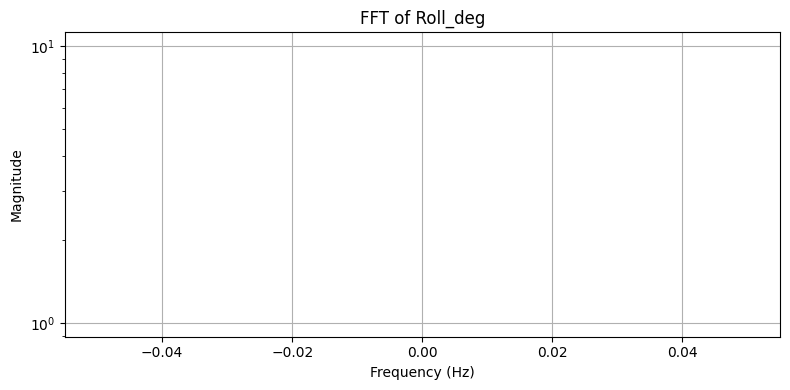

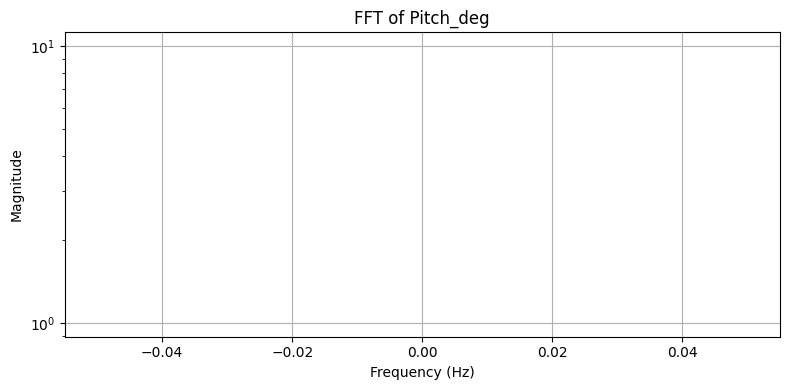

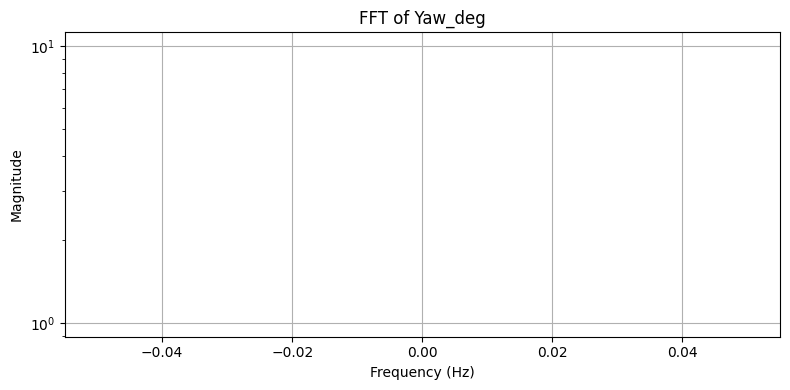

In [9]:
from scipy.fft import rfft, rfftfreq

def plot_fft(signal, fs, label):
    N = len(signal)
    yf = np.abs(rfft(signal - np.mean(signal)))
    xf = rfftfreq(N, 1 / fs)

    plt.figure(figsize=(8, 4))
    plt.semilogy(xf, yf)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title(f"FFT of {label}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Estimate sampling frequency
dt = np.diff(df["Flight_Time_(s)"]).mean()
fs = 1 / dt

for angle in ["Roll_deg", "Pitch_deg", "Yaw_deg"]:
    plot_fft(df[angle], fs, angle)
